<a href="https://colab.research.google.com/github/mehdihasan010/Learn_ML/blob/master/EggplantLeafDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import itertools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Eggplant_Disease_Dataset'
ds_name = 'Eggplant Leaf Disease'

In [ ]:
def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [ ]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)

    return df

df = create_df(filepaths, labels)

In [ ]:
df

,filepaths,labels
0,/content/drive/MyDrive/Eggplant_Disease_Datase...,White Mold Disease
1,/content/drive/MyDrive/Eggplant_Disease_Datase...,White Mold Disease
2,/content/drive/MyDrive/Eggplant_Disease_Datase...,White Mold Disease
3,/content/drive/MyDrive/Eggplant_Disease_Datase...,White Mold Disease
4,/content/drive/MyDrive/Eggplant_Disease_Datase...,White Mold Disease
...,...,...
3154,/content/drive/MyDrive/Eggplant_Disease_Datase...,Mosaic Virus Disease
3155,/content/drive/MyDrive/Eggplant_Disease_Datase...,Mosaic Virus Disease
3156,/content/drive/MyDrive/Eggplant_Disease_Datase...,Mosaic Virus Disease
3157,/content/drive/MyDrive/Eggplant_Disease_Datase...,Mosaic Virus Disease


In [ ]:
def num_of_examples(df, name='df'):
    print(f"{name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

Eggplant Leaf Disease dataset has 3159 images.


In [ ]:
def num_of_classes(df, name='df'):
    print(f"{name} dataset has {len(df['labels'].unique())} classes.")

num_of_classes(df, ds_name)

Eggplant Leaf Disease dataset has 7 classes.


In [ ]:
def classes_count(df, name='df'):

    print(f"{name} dataset: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"'{name}'class has  {num_class} images. ")
        print('-'*70)

classes_count(df, ds_name)

Eggplant Leaf Disease dataset: 

'White Mold Disease'class has  64 images. 
----------------------------------------------------------------------
'Leaf Spot Disease'class has  896 images. 
----------------------------------------------------------------------
'Insect Pest Disease'class has  767 images. 
----------------------------------------------------------------------
'Healthy Leaf'class has  536 images. 
----------------------------------------------------------------------
'Wilt Disease'class has  496 images. 
----------------------------------------------------------------------
'Small Leaf Disease'class has  112 images. 
----------------------------------------------------------------------
'Mosaic Virus Disease'class has  288 images. 
----------------------------------------------------------------------


In [ ]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentage Chart'),
                        specs=[[{"type": "bar"}, {'type': 'pie'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=20),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors)),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

cat_summary_with_graph(df,'labels')

In [ ]:
def check_null_values(df, name='df'):

    num_null_vals = sum(df.isnull().sum().values)

    if not num_null_vals:
        print(f"{name} DataFrame has no null values.")

    else:
        print(f"The {name} DataFrame has {num_null_vals} null values.")
        print('-'*70)
        print('Total null values in each column:')
        print(df.isnull().sum())


check_null_values(df, ds_name)

Eggplant Leaf Disease DataFrame has no null values.


In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [ ]:
def num_imgs(df, name='df'):
    print(f"{name} set contains {len(df)} images.")

In [ ]:
num_imgs(train_df, 'Training ')
num_imgs(valid_df, 'Validation ')
num_imgs(test_df, 'Testing ')

Training  set contains 2211 images.
Validation  set contains 474 images.
Testing  set contains 474 images.


In [ ]:
num_of_classes(train_df, "Training ")
num_of_classes(valid_df, "Validation ")
num_of_classes(test_df, "Testing ")

Training  dataset has 7 classes.
Validation  dataset has 7 classes.
Testing  dataset has 7 classes.


In [ ]:
classes_count(train_df, 'Training '+ds_name)

Training Eggplant Leaf Disease dataset: 

'Insect Pest Disease'class has  541 images. 
----------------------------------------------------------------------
'Leaf Spot Disease'class has  638 images. 
----------------------------------------------------------------------
'Wilt Disease'class has  346 images. 
----------------------------------------------------------------------
'White Mold Disease'class has  48 images. 
----------------------------------------------------------------------
'Healthy Leaf'class has  363 images. 
----------------------------------------------------------------------
'Small Leaf Disease'class has  73 images. 
----------------------------------------------------------------------
'Mosaic Virus Disease'class has  202 images. 
----------------------------------------------------------------------


In [ ]:
classes_count(valid_df, 'Validation '+ds_name)

Validation Eggplant Leaf Disease dataset: 

'Leaf Spot Disease'class has  128 images. 
----------------------------------------------------------------------
'Insect Pest Disease'class has  120 images. 
----------------------------------------------------------------------
'Wilt Disease'class has  65 images. 
----------------------------------------------------------------------
'Mosaic Virus Disease'class has  46 images. 
----------------------------------------------------------------------
'Healthy Leaf'class has  86 images. 
----------------------------------------------------------------------
'White Mold Disease'class has  7 images. 
----------------------------------------------------------------------
'Small Leaf Disease'class has  22 images. 
----------------------------------------------------------------------


In [ ]:
classes_count(test_df, 'Testing '+ds_name)

Testing Eggplant Leaf Disease dataset: 

'Insect Pest Disease'class has  106 images. 
----------------------------------------------------------------------
'Healthy Leaf'class has  87 images. 
----------------------------------------------------------------------
'Leaf Spot Disease'class has  130 images. 
----------------------------------------------------------------------
'Wilt Disease'class has  85 images. 
----------------------------------------------------------------------
'Mosaic Virus Disease'class has  40 images. 
----------------------------------------------------------------------
'Small Leaf Disease'class has  17 images. 
----------------------------------------------------------------------
'White Mold Disease'class has  9 images. 
----------------------------------------------------------------------


In [ ]:
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size


def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col = 'filepaths',
                                       y_col= 'labels',
                                       target_size = img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 2211 validated image filenames belonging to 7 classes.
Found 474 validated image filenames belonging to 7 classes.
Found 474 validated image filenames belonging to 7 classes.


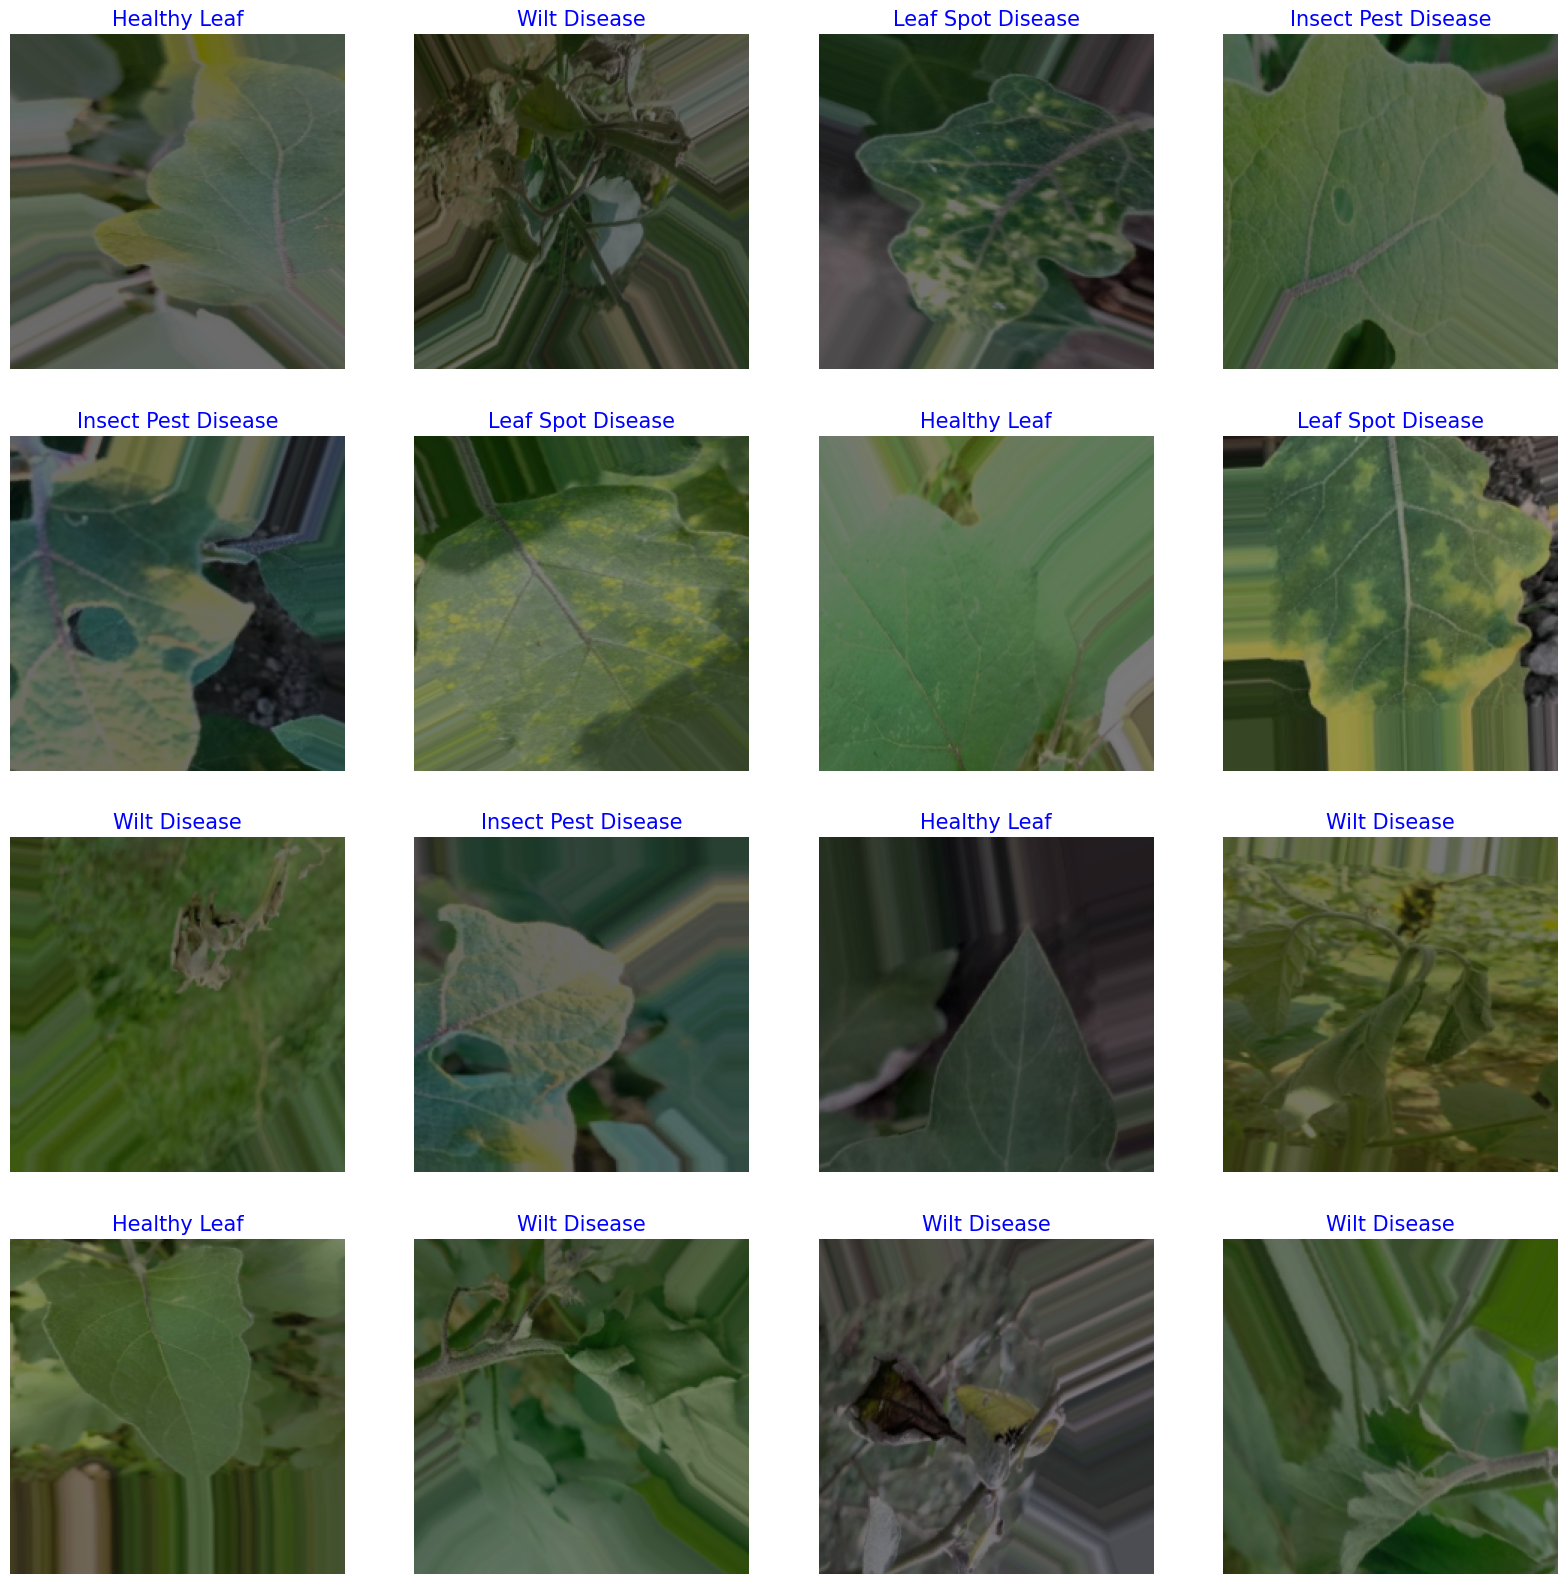

In [ ]:
g_dict = train_gen.class_indices

classes = list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):

    plt.subplot(4, 4, i + 1)

    image = images[i] / 255

    plt.imshow(image)

    index = np.argmax(labels[i])

    class_name = classes[index]

    plt.title(class_name, color='blue', fontsize=15)

    plt.axis('off')

plt.show()

In [ ]:
img_size = (224, 224)

channels = 3

img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(128, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])
model.compile(Adamax(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               327808    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                       

In [ ]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0

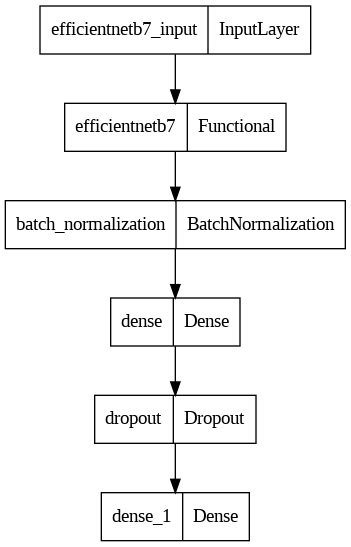

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               mode='min',
                              )

In [ ]:
batch_size = 16
epochs = 30

history = model.fit(x=train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = valid_gen,
                    validation_steps = None,
                    shuffle = False,
                    batch_size = batch_size,
                    callbacks = [early_stopping])

Epoch 1/30
56/56 [==============================] - 1039s 18s/step - loss: 5.7651 - accuracy: 0.5129 - val_loss: 5.4207 - val_accuracy: 0.4557
Epoch 2/30
56/56 [==============================] - 63s 1s/step - loss: 4.5106 - accuracy: 0.6174 - val_loss: 3.8542 - val_accuracy: 0.6983
Epoch 3/30
56/56 [==============================] - 61s 1s/step - loss: 3.7379 - accuracy: 0.7042 - val_loss: 3.3306 - val_accuracy: 0.7342
Epoch 4/30
56/56 [==============================] - 61s 1s/step - loss: 3.2495 - accuracy: 0.7069 - val_loss: 2.8599 - val_accuracy: 0.7595
Epoch 5/30
56/56 [==============================] - 65s 1s/step - loss: 2.8301 - accuracy: 0.7422 - val_loss: 2.5410 - val_accuracy: 0.7679
Epoch 6/30
56/56 [==============================] - 62s 1s/step - loss: 2.5605 - accuracy: 0.7295 - val_loss: 2.2833 - val_accuracy: 0.7553
Epoch 7/30
56/56 [==============================] - 64s 1s/step - loss: 2.2341 - accuracy: 0.7612 - val_loss: 2.0748 - val_accuracy: 0.7658
Epoch 8/30
56/56 

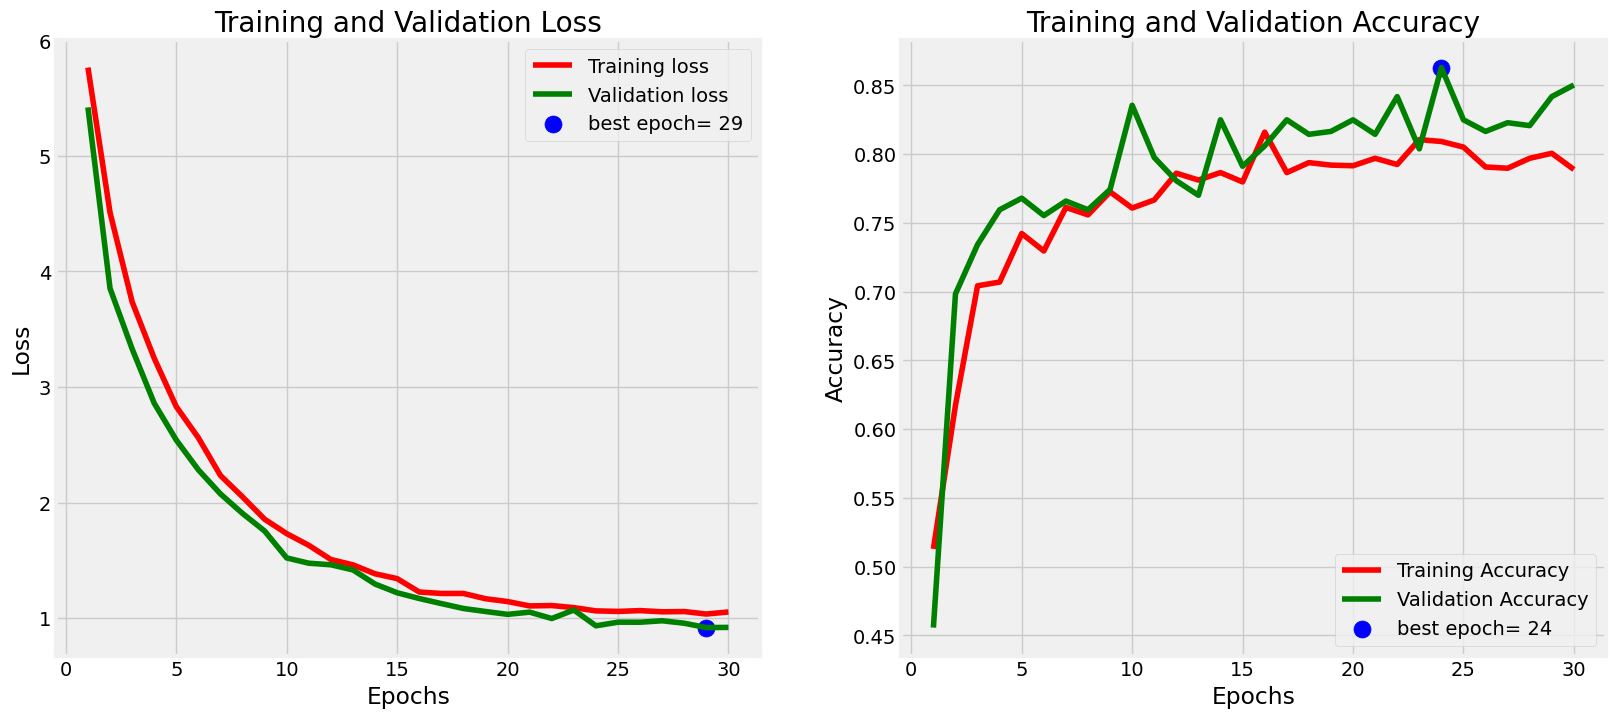

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuary: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

6/6 [==============================] - 145s 27s/step - loss: 0.9010 - accuracy: 0.8565
Train Loss:  0.8804091215133667
Train Accuary:  0.8708333373069763
--------------------
Validation Loss:  0.9515416622161865
Validation Accuracy:  0.8041666746139526
--------------------
Test Loss:  0.9010137319564819
Test Accuracy:  0.8565400838851929


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())


cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                      precision    recall  f1-score   support

        Healthy Leaf       0.80      0.70      0.75        87
 Insect Pest Disease       0.80      0.91      0.85       106
   Leaf Spot Disease       0.83      0.84      0.84       130
Mosaic Virus Disease       0.94      0.85      0.89        40
  Small Leaf Disease       0.94      0.88      0.91        17
  White Mold Disease       0.89      0.89      0.89         9
        Wilt Disease       0.95      0.96      0.96        85

            accuracy                           0.85       474
           macro avg       0.88      0.86      0.87       474
        weighted avg       0.86      0.85      0.85       474



In [ ]:
model.save('my_model.h5')

1/1 [==============================] - 7s 7s/step


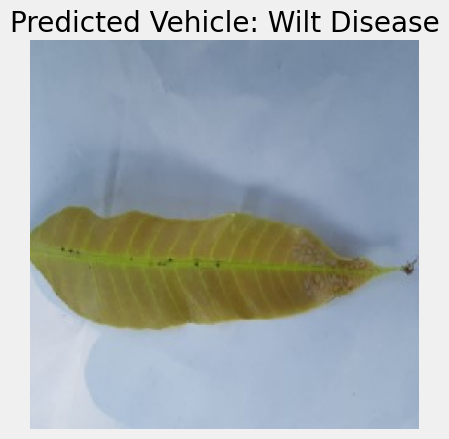

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Vehicle: {predicted_class_label}")
    plt.show()


model.load_weights('/content/my_model.h5')


class_labels = list(train_gen.class_indices.keys())



image_path_to_test = '/content/drive/MyDrive/Eggplant_Disease_Dataset/Small_Leaf_Disease/smallleaf_aug0014.jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
print(class_labels)

In [ ]:
# Load the h5 model
model = tf.keras.models.load_model('/content/my_model.h5')
model.summary()

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               327808    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 64436638 (245.81 MB)
Trainable params: 333

In [ ]:
model.save_weights('my_model_widgets.h5')